## Prep to run this notebook:
- python scripts/run_vk_ref_geuvadis.py
- python scripts/run_vk_count_ccle.py
- *run notebooks/Fig1_single_cell_analysis.ipynb*

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [1]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import numpy as np
import shutil
import seaborn as sns
import gget
import re
from collections import Counter
import anndata as ad
from scipy import sparse
import scanpy as sc
from sklearn.metrics import silhouette_score
from upsetplot import UpSet, from_contents
from scipy.stats import hypergeom

import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
data_dir = os.path.join(RLSRWP_2025_dir, "data")

In [53]:
sequencing_data_out_base = os.path.join(data_dir, "ccle_data_base")
adata_combined_path_variants = os.path.join(sequencing_data_out_base, "adata_vcrs_glioblastoma.h5ad")
# adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_vcrs_combined_w37_k41.h5ad")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
t2g_file = os.path.join(reference_dir, "ensembl_grch37_release113", "t2g.txt")

cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")

out_dir = os.path.join(data_dir, "ccle_analysis")
cbioportal_mutated_genes_path = os.path.join(data_dir, 'vk_count_out_fig1', 'analysis', 'single_cell_analysis', "Mutated_Genes.txt")  # os.path.join(out_dir, "Mutated_Genes.txt")
single_cell_gbm_variants_path = os.path.join(data_dir, 'vk_count_out_fig1', 'analysis', 'single_cell_analysis', 'variants_df_astrocytes.csv')
single_cell_gbm_genes_path = os.path.join(data_dir, 'vk_count_out_fig1', 'analysis', 'single_cell_analysis', 'genes_grouped_df_astrocytes.csv')

min_counts = 2
min_samples_per_variant = 2  # somewhat redundant with fsv_threshold_ccle

# for all of these, do None to get everything
fsv_threshold_ccle = 0.5  # keep in mind there are 38 samples
number_cbio_samples = 10

out_dir = os.path.join(data_dir, "ccle_analysis_total")

In [ ]:
if not os.path.isfile(adata_combined_path_variants):
    vk.utils.download_box_url(box_links_dict["ccle_glioblastoma_adata_vcrs"], output_file_name=adata_combined_path_variants)
if not os.path.isfile(cosmic_csv):
    gget.cosmic(None, grch_version=37, cosmic_version=101, out=os.path.dirname(cosmic_csv), cosmic_project="cancer", download_cosmic=True, gget_mutate=True, keep_genome_info=True, remove_duplicates=True)
if not os.path.isfile(cbioportal_mutated_genes_path):
    raise FileExistsError(f"{cbioportal_mutated_genes_path} does not exist. Download by visiting https://www.cbioportal.org/study/summary?id=gbm_tcga_pan_can_atlas_2018 → click 'mutated genes'")
if not os.path.isfile(single_cell_gbm_variants_path):
    raise FileExistsError(f"{single_cell_gbm_variants_path} does not exist. Please run Fig1_single_cell_analysis.ipynb to generate this file.")
if not os.path.isfile(single_cell_gbm_genes_path):
    raise FileExistsError(f"{single_cell_gbm_genes_path} does not exist. Please run Fig1_single_cell_analysis.ipynb to generate this file.")

adata = ad.read_h5ad(adata_combined_path_variants)
cosmic_df = pd.read_csv(cosmic_csv)
cbioportal_mutated_genes_df = pd.read_csv(cbioportal_mutated_genes_path, sep="\t")
cbioportal_mutated_genes_df = cbioportal_mutated_genes_df.sort_values(by="#", ascending=False)
single_cell_gbm_variants_df = pd.read_csv(single_cell_gbm_variants_path)

os.makedirs(out_dir, exist_ok=True)

In [56]:
# Filter to keep only rows where "#" is >= number_cbio_samples
cbioportal_mutated_genes_df_top = cbioportal_mutated_genes_df[cbioportal_mutated_genes_df["#"] >= number_cbio_samples] if number_cbio_samples is not None else cbioportal_mutated_genes_df.copy()

# only keep columns of adata where adata.var['gene_symbol'] is in cbioportal_mutated_genes_df['Gene'].unique()
cbio_gbm_genes = set(cbioportal_mutated_genes_df_top['Gene'].unique())

In [ ]:
adata = adata[:, ~adata.var_names.str.contains(";")]  # Identify columns (variants) with semicolon in name
adata.var.index.name = "variant_name"
adata.var = adata.var.reset_index(drop=False)
adata.var[["seq_ID", "mutation_cdna"]] = adata.var["variant_name"].str.split(":", expand=True)
adata.var = adata.var.merge(cosmic_df[["seq_ID", "gene_name"]].drop_duplicates("seq_ID"), on="seq_ID", how="left").rename(columns={"gene_name": "gene_symbol"})

if min_counts is not None:
    adata.X = adata.X.multiply(adata.X >= min_counts)

adata = adata[:, np.array((adata.X != 0).sum(axis=0)).flatten() > min_samples_per_variant]  # Identify columns (variants) with non-zero counts across samples

adata.var["number_obs"] = np.array((adata.X != 0).sum(axis=0)).flatten()

adata.var["FSV"] = adata.var["number_obs"] / adata.shape[0]  # fraction of samples with variant - Fraction of Samples with Variant (FSV)

adata.var['variant_name_with_gene_name'] = (
    adata.var["gene_symbol"] + "(" +
    adata.var["seq_ID"] + "):" +
    adata.var["mutation_cdna"]
)

adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
adata.var.index = adata.var.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names

fsv_threshold_ccle_for_title = str(fsv_threshold_ccle).replace(".", "_") if fsv_threshold_ccle is not None else "all"

In [58]:
adata

AnnData object with n_obs × n_vars = 38 × 245749
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'primary_disease', 'subtype_disease', 'sex', 'age', 'lineage_subtype', 'Cellosaurus_NCIt_disease', 'lineage'
    var: 'variant_name', 'seq_ID', 'mutation_cdna', 'gene_symbol', 'number_obs', 'FSV', 'variant_name_with_gene_name'

Text(0.5, 1.0, 'Histogram of FSV for variants in CCLE')

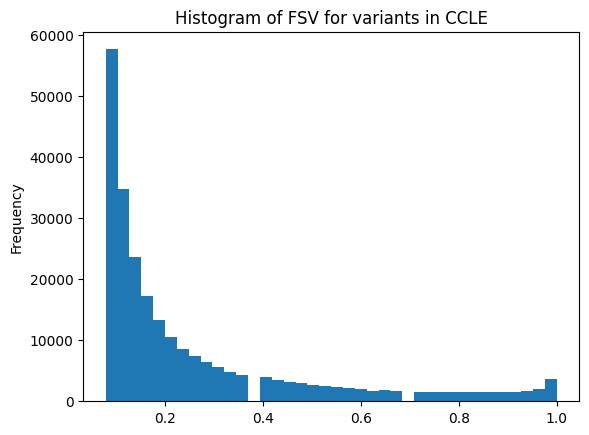

In [59]:
# quick histogram of number_obs
adata.var["FSV"].plot.hist(bins=38).set_title("Histogram of FSV for variants in CCLE")

In [60]:
adata.var.head()

,variant_name,seq_ID,mutation_cdna,gene_symbol,number_obs,FSV,variant_name_with_gene_name
48,ENST00000396153:c.1953C>T,ENST00000396153,c.1953C>T,FAF1,3,0.078947,FAF1(ENST00000396153):c.1953C>T
54,ENST00000396153:c.794G>T,ENST00000396153,c.794G>T,FAF1,3,0.078947,FAF1(ENST00000396153):c.794G>T
96,ENST00000396153:c.1977A>G,ENST00000396153,c.1977A>G,FAF1,5,0.131579,FAF1(ENST00000396153):c.1977A>G
98,ENST00000396153:c.1363T>G,ENST00000396153,c.1363T>G,FAF1,14,0.368421,FAF1(ENST00000396153):c.1363T>G
107,ENST00000396153:c.2217C>T,ENST00000396153,c.2217C>T,FAF1,3,0.078947,FAF1(ENST00000396153):c.2217C>T


In [61]:
single_cell_gbm_variants_df.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name_instead_of_transcript_id,variant_name_with_gene_name,FCV_neoplastic_astrocyte,FCV_healthy_astrocyte,cancer_specific,simplified_role
0,ENST00000396153:c.1592C>T,FAF1,3.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1592C>T,1592,C>T,1592.0,1592.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1592C>T,FAF1:c.1592C>T,FAF1(ENST00000396153):c.1592C>T,0.000000,0.011364,False,NaN
1,ENST00000396153:c.2261A>G,FAF1,5.0,49,2,0.000557,NaN,NaN,NaN,ENST00000396153,c.2261A>G,2261,A>G,2261.0,2261.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.2261A>G,FAF1:c.2261A>G,FAF1(ENST00000396153):c.2261A>G,0.000917,0.000000,False,NaN
2,ENST00000396153:c.1823G>A,FAF1,5.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1823G>A,1823,G>A,1823.0,1823.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1823G>A,FAF1:c.1823G>A,FAF1(ENST00000396153):c.1823G>A,0.000000,0.000000,False,NaN
3,ENST00000396153:c.1391G>T,FAF1,2.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1391G>T,1391,G>T,1391.0,1391.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1391G>T,FAF1:c.1391G>T,FAF1(ENST00000396153):c.1391G>T,0.000000,0.000000,False,NaN
4,ENST00000396153:c.1325C>T,FAF1,3.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1325C>T,1325,C>T,1325.0,1325.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1325C>T,FAF1:c.1325C>T,FAF1(ENST00000396153):c.1325C>T,0.000917,0.000000,False,NaN


In [62]:
ccle_gbm_variants = set(adata.var.loc[adata.var["FSV"] >= fsv_threshold_ccle, "variant_name"]) if fsv_threshold_ccle is not None else set(adata.var["variant_name"])
ccle_gbm_genes = set(adata.var.loc[adata.var["FSV"] >= fsv_threshold_ccle, "gene_symbol"]) if fsv_threshold_ccle is not None else set(adata.var["gene_symbol"])

sc_gbm_variants = set(single_cell_gbm_variants_df.loc[single_cell_gbm_variants_df["cancer_specific"], "variant_name"])
sc_gbm_genes = set(single_cell_gbm_variants_df.loc[single_cell_gbm_variants_df["variant_name"].isin(sc_gbm_variants), "gene_symbol"])

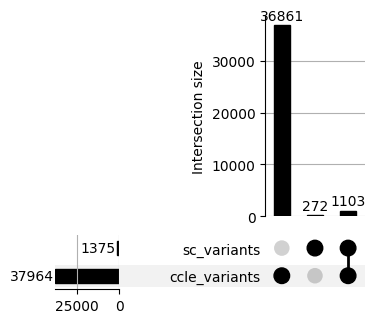

In [ ]:
# variants present in both ccle (in a certain fraction of samples) and sc (with certain neoplastic astrocyte to healthy astrocyte ratio)
upset_dict = {
    "ccle_variants": ccle_gbm_variants,
    "sc_variants": sc_gbm_variants,
}

upset_out_path = os.path.join(out_dir, f"upset_variants_detected_{fsv_threshold_ccle_for_title}_fsv_threshold_ccle.pdf")
variants_detected_data_for_upset = from_contents(upset_dict)
ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
plt.savefig(upset_out_path)

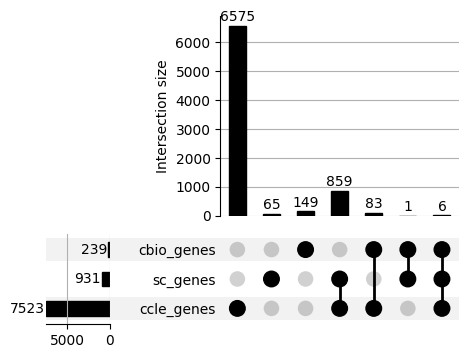

In [ ]:
# variants present in ccle (in a certain fraction of samples), sc (with certain max neoplastic astrocyte to healthy astrocyte ratio), and cbio (in a certain number of samples)
upset_dict = {
    "ccle_genes": ccle_gbm_genes,
    "sc_genes": sc_gbm_genes,
    "cbio_genes": cbio_gbm_genes,
}

upset_out_path = os.path.join(out_dir, f"upset_genes_detected_{fsv_threshold_ccle_for_title}_fsv_threshold_ccle.pdf")
variants_detected_data_for_upset = from_contents(upset_dict)
ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
plt.savefig(upset_out_path)

## How much of this is by chance?

In [66]:
total_variants_cosmic_cmc = len(cosmic_df)
total_genes_cosmic_cmc = len(cosmic_df['gene_name'].unique())

total_variants_ccle_gbm = len(ccle_gbm_variants)
total_genes_ccle_gbm = len(ccle_gbm_genes)

total_variants_sc = len(sc_gbm_variants)
total_genes_sc = len(sc_gbm_genes)

variant_overlap_between_ccle_and_sc = len(ccle_gbm_variants.intersection(sc_gbm_variants))
gene_overlap_between_ccle_and_sc = len(ccle_gbm_genes.intersection(sc_gbm_genes))

In [68]:
def compute_overlap_p_value(N, n1, n2, observed_overlap, element_name = "element"):
    """
    N: population size (e.g., total number of variants/genes in cosmic_cmc)
    n1: sample size 1 (e.g., number of variants/genes in ccle)
    n2: sample size 2 (e.g., number of variants/genes in sc)
    """
    print(f"""element name: {element_name}
N (population size): {N}
n1 (sample size 1): {n1}
n2 (sample size 2): {n2}
""")

    expected_overlap = (n1 * n2) / N
    print(f"Expected {element_name} overlap: {expected_overlap}")
    print(f"Observed {element_name} overlap: {observed_overlap}")

    # Hypergeometric distribution
    rv = hypergeom(N, n1, n2)

    # Compute p-value (right-tail)
    p_value = rv.sf(observed_overlap - 1)

    if p_value == 0:
        print(f"Right-tail p-value for observed {element_name} overlap {observed_overlap}: <1e-308")
    else:
        print(f"Right-tail p-value for observed {element_name} overlap {observed_overlap}: {p_value:.4g}")

    return p_value


variant_p_value = compute_overlap_p_value(
    N=total_variants_cosmic_cmc,
    n1=total_variants_ccle_gbm,
    n2=total_variants_sc,
    observed_overlap=variant_overlap_between_ccle_and_sc,
    element_name = "variant"
)

print("--------------------------")

gene_p_value = compute_overlap_p_value(
    N=total_genes_cosmic_cmc,
    n1=total_genes_ccle_gbm,
    n2=total_genes_sc,
    observed_overlap=gene_overlap_between_ccle_and_sc,
    element_name = "gene"
)

element name: variant
N (population size): 5419494
n1 (sample size 1): 37964
n2 (sample size 2): 1375

Expected variant overlap: 9.631987783361325
Observed variant overlap: 1103
Right-tail p-value for observed variant overlap 1103: <1e-308
--------------------------
element name: gene
N (population size): 19993
n1 (sample size 1): 7523
n2 (sample size 2): 931

Expected gene overlap: 350.318261391487
Observed gene overlap: 865
Right-tail p-value for observed gene overlap 865: 3.35e-292


Safe to say it's not by chance...

## FSV to FCV scatter plot

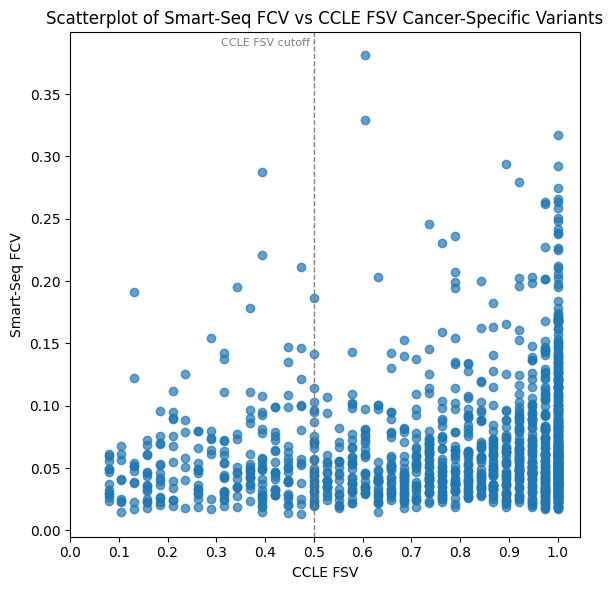

In [ ]:
num_variants_to_annotate = 0
plot_only_cbio = False

scatterplot_df = single_cell_gbm_variants_df.merge(
    adata.var[["variant_name", "FSV"]],
    on="variant_name",
    how="left"
)

scatterplot_df = scatterplot_df.loc[scatterplot_df["cancer_specific"]]
if plot_only_cbio:
    scatterplot_df = scatterplot_df.loc[scatterplot_df["gene_symbol"].isin(cbio_gbm_genes)]

plt.figure(figsize=(6,6))
plt.scatter(
    scatterplot_df["FSV"],
    scatterplot_df["FCV"],
    alpha=0.7,
)

if num_variants_to_annotate > 0:
    top_var = scatterplot_df[scatterplot_df["FSV"] < fsv_threshold_ccle].nlargest(num_variants_to_annotate, "FCV")
    # top_var = scatterplot_df.nlargest(num_variants_to_annotate, "FCV")
    for _, row in top_var.iterrows():
        plt.text(
            row["FSV"],
            row["FCV"],
            row["variant_name_with_gene_name_instead_of_transcript_id"],
            fontsize=8,
            ha="right",
            va="bottom"
        )

plt.axvline(
    x=fsv_threshold_ccle,
    color="gray",
    linestyle="--",
    linewidth=1,
)

plt.text(
    fsv_threshold_ccle,             # x position
    max(scatterplot_df["FCV"])*1.02,                                # y position (top of the plot)
    f"CCLE FSV cutoff ", # label text
    ha="right",
    color="gray",
    fontsize=8
)

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("CCLE FSV")
plt.ylabel("Smart-Seq FCV")
plt.title("Scatterplot of Smart-Seq FCV vs CCLE FSV Cancer-Specific Variants")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"scatterplot_fsv_vs_fcv_{fsv_threshold_ccle_for_title}_fsv_threshold_ccle.pdf"))
plt.show()
plt.close()

## Let's look at those intersecting genes

In [102]:
gene_intersection = sorted(ccle_gbm_genes & sc_gbm_genes & cbio_gbm_genes)
print(gene_intersection)

['EGFR', 'LAMA5', 'LRP1', 'NOTCH2', 'PIK3R1', 'SRRM2']


## How about the variants?

In [103]:
variant_intersection = sorted(ccle_gbm_variants & sc_gbm_variants)
filtered_df = adata.var[adata.var["variant_name"].isin(variant_intersection)].copy()

### Look at the variants that intersect sc and CCLE, and sort by the fraction of samples in which each variant is present in CCLE

In [104]:
filtered_df.head()

,variant_name,seq_ID,mutation_cdna,gene_symbol,number_obs,FSV,variant_name_with_gene_name
1598,ENST00000371218:c.700G>A,ENST00000371218,c.700G>A,FGGY,27,0.710526,FGGY(ENST00000371218):c.700G>A
1874,ENST00000371108:c.1216C>T,ENST00000371108,c.1216C>T,ALG6,38,1.000000,ALG6(ENST00000371108):c.1216C>T
2197,ENST00000371083:c.1680T>C,ENST00000371083,c.1680T>C,PGM1,26,0.684211,PGM1(ENST00000371083):c.1680T>C
7941,ENST00000358465:c.2603T>C,ENST00000358465,c.2603T>C,TRIM33,36,0.947368,TRIM33(ENST00000358465):c.2603T>C
15487,ENST00000376957:c.183A>G,ENST00000376957,c.183A>G,SRM,38,1.000000,SRM(ENST00000376957):c.183A>G


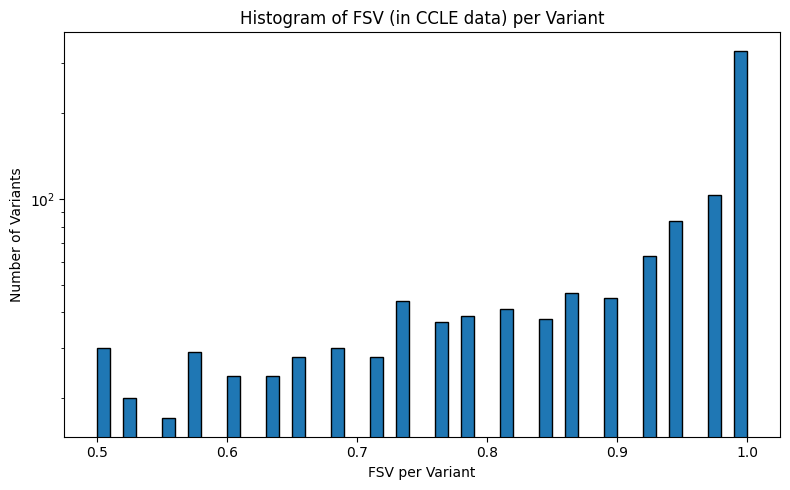

In [105]:
plt.figure(figsize=(8,5))
plt.hist(filtered_df["FSV"].dropna(), bins=50, edgecolor='black')
plt.xlabel("FSV per Variant")
plt.yscale('log')
plt.ylabel("Number of Variants")
plt.title("Histogram of FSV (in CCLE data) per Variant")
plt.tight_layout()
plt.show()

In [106]:
FSV_threshold_tmp = 0.9

high_fsv_df = filtered_df[filtered_df["FSV"] >= FSV_threshold_tmp]
high_fsv_genes = set(high_fsv_df["gene_symbol"])

print(f"Number of variants both with tumor specificity in single cell data AND with CCLE FSV >= {FSV_threshold_tmp}: {len(high_fsv_df)}")
print(f"Number of genes both with tumor specificity in single cell data AND with CCLE FSV >= {FSV_threshold_tmp}: {len(high_fsv_genes)}")
# print(high_fsv_genes)

high_fsv_genes_also_in_cbio = high_fsv_genes & cbio_gbm_genes
print(f"Number of genes with tumor specificity in single cell data AND CCLE FSV >= {FSV_threshold_tmp} AND also in cBioPortal: {len(high_fsv_genes_also_in_cbio)}")
print(high_fsv_genes_also_in_cbio)

Number of variants both with tumor specificity in single cell data AND with CCLE FSV >= 0.9: 582
Number of genes both with tumor specificity in single cell data AND with CCLE FSV >= 0.9: 380
Number of genes with tumor specificity in single cell data AND CCLE FSV >= 0.9 AND also in cBioPortal: 2
{'LAMA5', 'NOTCH2'}


### Look at the variants that intersect sc and CCLE, and sort by number of variants in each gene

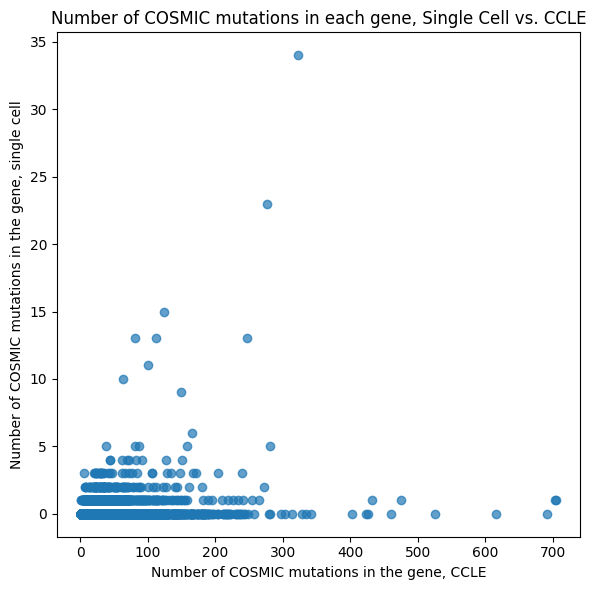

In [147]:
gene_counts_single_cell = (
    single_cell_gbm_variants_df["gene_symbol"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "gene_count_sc"})
)

gene_counts_ccle = (
    filtered_df["gene_symbol"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "gene_count_ccle"})
)

gene_counts_df = gene_counts_single_cell.merge(
    gene_counts_ccle,
    on="gene_symbol",
    how="outer"
).fillna(0)

plt.figure(figsize=(6,6))
plt.scatter(
    gene_counts_df["gene_count_sc"],
    gene_counts_df["gene_count_ccle"],
    alpha=0.7,
)

plt.xlabel("Number of COSMIC mutations in the gene, CCLE")
plt.ylabel("Number of COSMIC mutations in the gene, single cell")
plt.title("Number of COSMIC mutations in each gene, Single Cell vs. CCLE")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"scatterplot_mutation_burden_{fsv_threshold_ccle_for_title}.pdf"))
plt.show()
plt.close()

In [ ]:
gene_counts = filtered_df["gene_symbol"].value_counts()

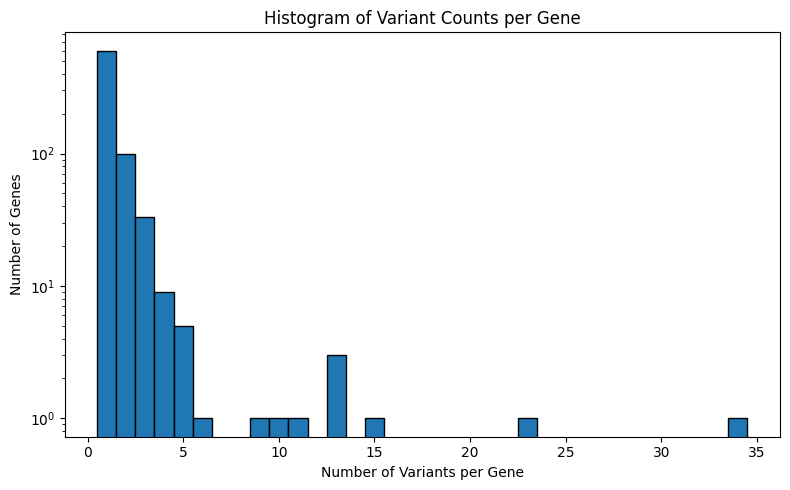

In [108]:
plt.figure(figsize=(8, 5))
plt.hist(gene_counts, bins=range(1, gene_counts.max() + 2), edgecolor='black', align='left')
plt.xlabel("Number of Variants per Gene")
plt.yscale('log')
plt.ylabel("Number of Genes")
plt.title("Histogram of Variant Counts per Gene")
# plt.xticks(range(1, gene_counts.max() + 1))
plt.tight_layout()
plt.show()

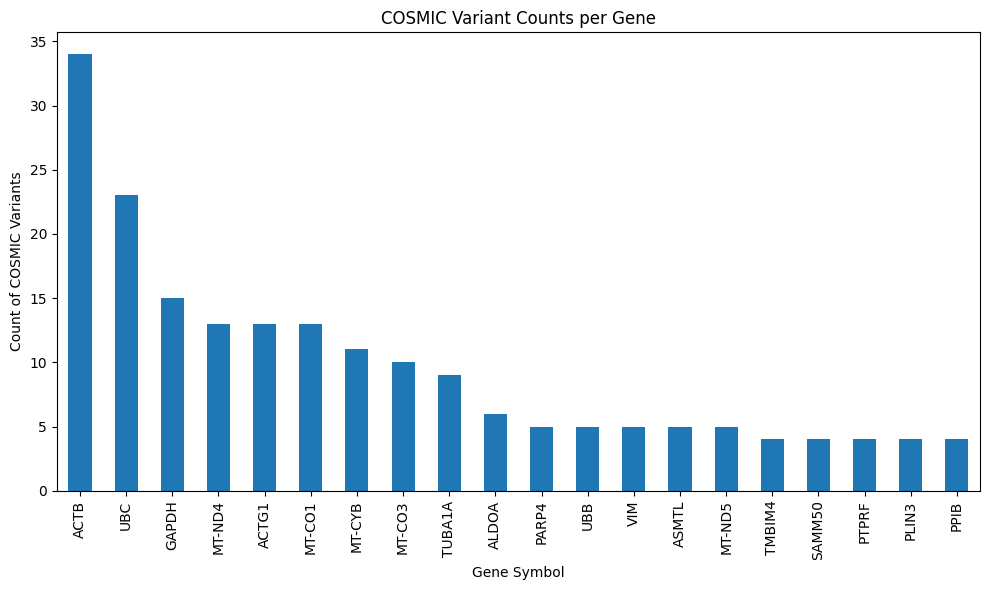

In [109]:
number_to_plot = 20

plt.figure(figsize=(10, 6))
gene_counts.sort_values(ascending=False).head(number_to_plot).plot.bar()
plt.xlabel("Gene Symbol")
plt.ylabel("Count of COSMIC Variants")
plt.title("COSMIC Variant Counts per Gene")
plt.tight_layout()
plt.show()

## Only the cbio ones

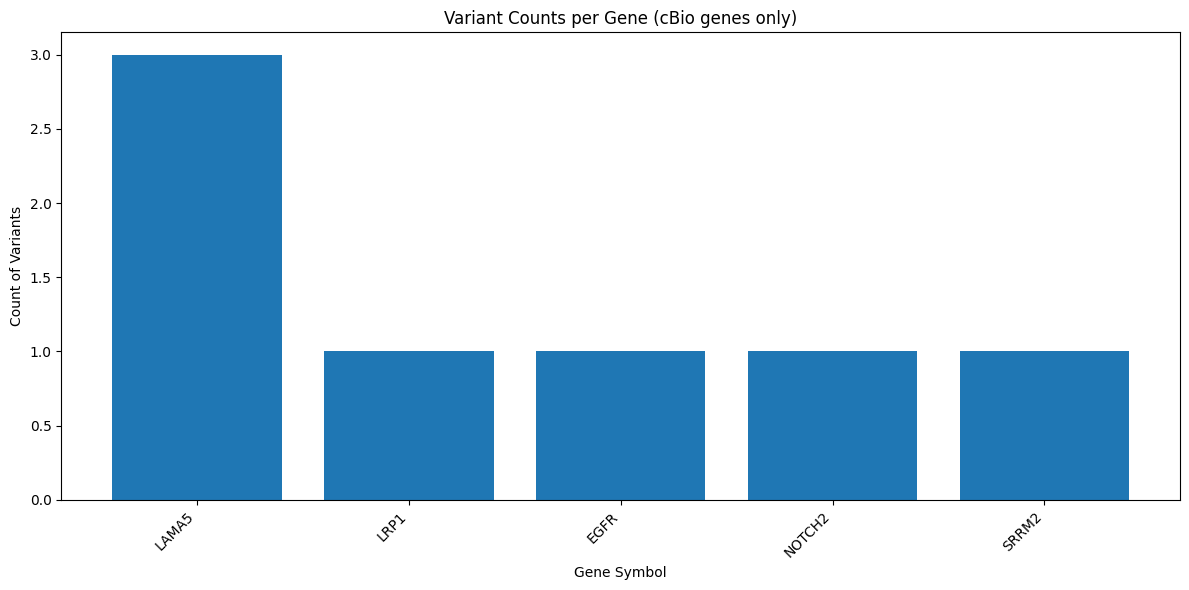

In [110]:
number_to_plot = 20

gene_counts_df = gene_counts.rename("count").reset_index()
gene_counts_df.rename(columns={"index": "gene_symbol"}, inplace=True)
gene_counts_df["in_cbio"] = gene_counts_df["gene_symbol"].isin(cbio_gbm_genes)
cbio_genes_df = gene_counts_df[gene_counts_df["in_cbio"]]

top_cbio_genes_df = cbio_genes_df.sort_values("count", ascending=False).head(number_to_plot)
plt.figure(figsize=(12, 6))
plt.bar(top_cbio_genes_df["gene_symbol"], top_cbio_genes_df["count"])
plt.xlabel("Gene Symbol")
plt.ylabel("Count of Variants")
plt.title("Variant Counts per Gene (cBio genes only)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()